In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 6
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/brettnaul/miniconda3/envs/deep/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
%run period.py 64 5 0.5 --model_type conv --sigma 2.0 --sim_type period/even/noise2 --filter 11
pred_conv = model.predict(X[test])

Using TensorFlow backend.


[]
/Users/brettnaul/Dropbox/Documents/timeflow/keras_logs/period/even/noise2/conv_064_x5_2m03_drop50_f11


In [3]:
%run period.py 64 3 0.25 --model_type gru --sigma 2.0 --sim_type period/even/noise1
pred_gru = model.predict(X[test])

[]
/Users/brettnaul/Dropbox/Documents/timeflow/keras_logs/period/even/noise1/gru_064_x3_2m03_drop25


In [4]:
%%time
from gatspy.periodic import LombScargle, LombScargleFast

pred_gatspy = np.zeros(pred_conv.shape)
for i in range(N_test):
#    opt_args = {'period_range': (0.1, 0.9 * (X[test[i]][-1, 0] - X[test[i]][0, 0])), 'quiet': True}
    opt_args = {'period_range': (0.05, 2 * np.pi), 'quiet': True}
    model_gatspy = LombScargle(fit_period=True, optimizer_kwds=opt_args)#, silence_warnings=True)
    model_gatspy.fit(np.linspace(0, 2 * np.pi, n_max), X[test[i]][:, 0])
    omega = 2 * np.pi / model_gatspy.best_period
    off, A1, A2 = model_gatspy._best_params(omega)
    pred_gatspy[i] = np.array([omega / 2 / np.pi, np.sqrt(A1 ** 2 + A2 ** 2), np.arctan2(A2, A1), off + model_gatspy.ymean_])

CPU times: user 1min 53s, sys: 744 ms, total: 1min 54s
Wall time: 1min 55s


In [5]:
i = -1

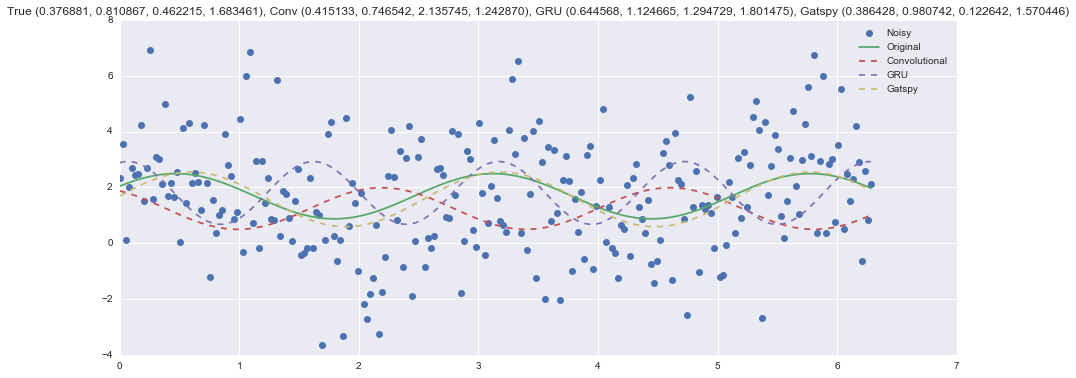

In [6]:
i += 1

t = np.linspace(0, 2 * np.pi, n_max)
x = X[test[i]].ravel()
plt.plot(t, x, 'o')

w, A, phi, b = Y[test[i]]
plt.plot(t, A * np.sin(2 * np.pi * w * t + phi) + b, '-')

w_c, A_c, phi_c, b_c = pred_conv[i]
x_c = A_c * np.sin(2 * np.pi * w_c * t + phi_c) + b_c
plt.plot(t, x_c, '--')

w_r, A_r, phi_r, b_r = pred_gru[i]
x_r = A_r * np.sin(2 * np.pi * w_r * t + phi_r) + b_r
plt.plot(t, x_r, '--')

#omega = 2 * np.pi / model_gatspy.best_period
#off, A1, A2 = model_gatspy._best_params(omega)
#w_g, A_g, phi_g, b_g = [omega / 2 / np.pi, np.sqrt(A1 ** 2 + A2 ** 2), np.arctan2(A2, A1), off + model_gatspy.ymean_]
w_g, A_g, phi_g, b_g = pred_gatspy[i]
x_g = A_g * np.sin(2 * np.pi * w_g * t + phi_g) + b_g
#x_g = model_gatspy.fit(t, x).predict(t)
plt.plot(t, x_g, '--')

plt.legend(['Noisy', 'Original', 'Convolutional', 'GRU', 'Gatspy'])
plt.title("True ({:3f}, {:3f}, {:3f}, {:3f}), Conv ({:3f}, {:3f}, {:3f}, {:3f}), GRU ({:3f}, {:3f}, {:3f}, {:3f}), Gatspy ({:3f}, {:3f}, {:3f}, {:3f})".format(
    w, A, phi, b,
    w_c, A_c, phi_c, b_c,
    w_r, A_r, phi_r, b_r,
    w_g, A_g, phi_g, b_g,
    ))

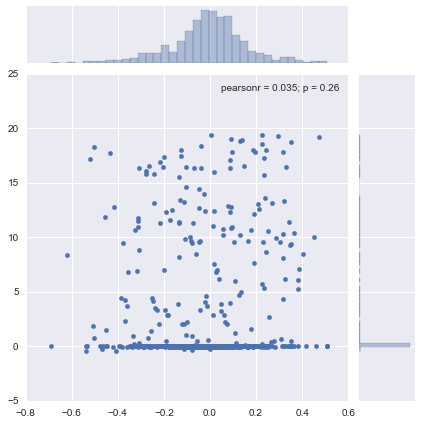

In [7]:
sns.jointplot(pred_conv[:, 0] - Y[test, 0], pred_gatspy[:, 0] - Y[test, 0])